# Instalando h2o en Google Colab

In [0]:
install.packages("h2o", dependencies = TRUE)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘httpuv’, ‘xtable’, ‘sourcetools’, ‘fastmap’, ‘miniUI’, ‘webshot’, ‘misc3d’, ‘bitops’, ‘bit’, ‘shiny’, ‘manipulateWidget’, ‘plot3D’, ‘RCurl’, ‘mlbench’, ‘slam’, ‘bit64’, ‘data.table’, ‘rgl’, ‘plot3Drgl’




# Grid XGBoost (500 modelos)

In [0]:
# Cargando datos
load("/content/df_test19.Rdata")
load("/content/df_train15.Rdata")

# ======================== Iniciando h2o ====================================== #
library(h2o)
h2o.init(nthreads = -1, port = 54321, max_mem_size = "10g")

# ======================= Train - Test h2o ==================================== #

# Editando train 2015 y test 2019
library(tidyverse)
df_train15 <- df_train %>% 
  dplyr::select(-Square_ID, -flood_15) %>% 
  mutate_each(funs(replace(., which(is.na(.)), mean(., na.rm=TRUE))))
df_test19 <- df_test %>% 
  dplyr::select(-Square_ID) %>% 
  mutate_each(funs(replace(., which(is.na(.)), mean(., na.rm=TRUE))))

# Datos h2o
datos_h2o <- as.h2o(x = df_train15, destination_frame = "datos_h2o")

particiones <- h2o.splitFrame(data = datos_h2o, ratios = c(0.65, 0.20),
                              seed = 123)
datos_train_h2o <- h2o.assign(data = particiones[[1]], key = "datos_train_H2o")
datos_val_h2o   <- h2o.assign(data = particiones[[2]], key = "datos_val_H2o")
datos_test_h2o  <- h2o.assign(data = particiones[[3]], key = "datos_test_H2o")

df_test_2019_h2o <- as.h2o(x = df_test19,
                           destination_frame = "datos_test19_h2o")

# Se define la variable respuesta y los predictores.
var_respuesta <- "target_2015"

# Para este modelo se emplean todos los predictores disponibles.
predictores   <- setdiff(h2o.colnames(datos_train_h2o), var_respuesta)

# ======================= XGBoost Grid =========================================== #
hyper_params <- list(ntrees = seq(1, 2000, 2),
                     learn_rate = seq(0.0001, 0.5, 0.0001),
                     max_depth = seq(1, 20, 1),
                     sample_rate = seq(0.2, 1.0, 0.0001),
                     col_sample_rate = seq(0.2, 1.0, 0.0001),
                     categorical_encoding = c("OneHotExplicit", "Binary"),
                     distribution = c("poisson", "gaussian", "gamma"),
                     tree_method = "hist",
                     grow_policy = "lossguide",
                     booster = c("gbtree", "gblinear"),
                     reg_lambda = seq(0, 1, 0.01),
                     reg_alpha =  seq(0, 1, 0.01),
                     min_rows = seq(1, 10, 1),
                     max_leaves = seq(1, 20, 1))

search_criteria <- list(strategy = "RandomDiscrete",
                        max_models = 500, 
                        seed = 123)


# Train the grid
xgb_grid <- h2o.grid(algorithm = "xgboost",
                     y = var_respuesta,
                     x = predictores,
                     training_frame = datos_train_h2o,
                     nfolds = 5,
                     seed = 123,
                     hyper_params = hyper_params,
                     search_criteria = search_criteria,
                     grid_id = "grid_xgb")

 Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         27 minutes 31 seconds 
    H2O cluster timezone:       Etc/UTC 
    H2O data parsing timezone:  UTC 
    H2O cluster version:        3.30.0.1 
    H2O cluster version age:    6 days  
    H2O cluster name:           H2O_started_from_R_root_etu167 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   9.96 GB 
    H2O cluster total cores:    2 
    H2O cluster allowed cores:  2 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    H2O Internal Security:      FALSE 
    H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, TargetEncoder, Core V4 
    R Version:                  R version 3.6.3 (2020-02-29) 



Warning message in mean.default(LC_Type1, na.rm = TRUE):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(long_factor, na.rm = TRUE):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(lat_factor, na.rm = TRUE):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(elev_factor, na.rm = TRUE):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(var_prec, na.rm = TRUE):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(LC_Type1, na.rm = TRUE):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(flood_15, na.rm = TRUE):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(long_factor, na.rm = TRUE):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(lat_factor, na.rm = TRUE):
“argument is not numeric or logical: returning NA”
Warning message

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%


# Resultados Grid XGBoost (ejecución: más de 10 horas)

In [0]:
# === Guardando Grid XGBoost === #
h2o.saveGrid(grid_directory = "GridXGBoost", grid_id = "grid_xgb")

# Resultados
resultados_grid_xgb <- h2o.getGrid(grid_id = "grid_xgb",
                                   sort_by = "RMSE",
                                   decreasing = FALSE)

# === Guardando mejor modelo === #
modelo_xgb1 <- h2o.getModel(resultados_grid_xgb@model_ids[[1]])
h2o.saveModel(object = modelo_xgb1, path = "modelo_xgb1",
              force = TRUE)

[1] "GridXGBoost/grid_xgb"

[1] "/content/modelo_xgb1/grid_xgb_model_502"

In [0]:
filesxgb <- dir('/content/GridXGBoost', full.names = TRUE)
zip(zipfile = 'GridXGB', files = filesxgb)

In [0]:
# Resumen de modelos
resultados_grid_xgb

H2O Grid Details

Grid ID: grid_xgb 
Used hyper parameters: 
  -  learn_rate 
  -  ntrees 
Number of models: 505 
Number of failed models: 0 

Hyper-Parameter Search Summary: ordered by increasing RMSE
  learn_rate ntrees          model_ids                rmse
1     0.0662   1859 grid_xgb_model_502 0.09947821895174623
2     0.1237   1127 grid_xgb_model_344 0.10020306782748674
3     0.0362   1963 grid_xgb_model_466 0.10143729627257667
4     0.0571   1741 grid_xgb_model_325 0.10153992383037579
5     0.0572    549  grid_xgb_model_94 0.10192976181452336

---
    learn_rate ntrees          model_ids rmse
500     0.4223    821 grid_xgb_model_471  NaN
501      0.177   1625 grid_xgb_model_476  NaN
502     0.2495   1337 grid_xgb_model_477  NaN
503     0.2673   1135 grid_xgb_model_497  NaN
504     0.1172   1397  grid_xgb_model_52  NaN
505     0.1517   1743  grid_xgb_model_66  NaN

In [0]:
modelo_xgb1

Model Details:

H2ORegressionModel: xgboost
Model ID:  grid_xgb_model_502 
Model Summary: 
  number_of_trees
1            1859


H2ORegressionMetrics: xgboost
** Reported on training data. **

MSE:  0.00110916
RMSE:  0.03330405
MAE:  0.01498288
RMSLE:  0.02604326
Mean Residual Deviance :  0.00110916



H2ORegressionMetrics: xgboost
** Reported on cross-validation data. **
** 5-fold cross-validation on training data (Metrics computed for combined holdout predictions) **

MSE:  0.009895916
RMSE:  0.09947822
MAE:  0.03978102
RMSLE:  0.07368393
Mean Residual Deviance :  0.009895916


Cross-Validation Metrics Summary: 
                              mean           sd  cv_1_valid  cv_2_valid
mae                     0.03981459 0.0021149116 0.037006598 0.040222526
mean_residual_deviance 0.009914339 8.9008897E-4 0.009099321 0.009551231
mse                    0.009914339 8.9008897E-4 0.009099321 0.009551231
r2                      0.81531507  0.010990329  0.80899614     0.82462
residual_deviance 

# Prredicciones

In [0]:
# Mejor modelo
# ============================= Predicciones ====================================== #

# Train 2015
predichos_train <- h2o.predict(modelo_xgb1, datos_train_h2o) %>%
  as.data.frame() %>% pull(predict)

# Test 2015
predichos_test <- h2o.predict(modelo_xgb1, datos_test_h2o) %>%
  as.data.frame() %>% pull(predict)

# Test 2019 (Zindi Submission)
predichos_2019 <- h2o.predict(modelo_xgb1, df_test_2019_h2o) %>%
  as.data.frame() %>% pull(predict)
df_test %>% 
  select(Square_ID) %>% 
  mutate(target_2019 = predichos_2019) ->
  predicciones47

# Exportando predicciones
write.csv(predicciones47, file = "Submussion47.csv", row.names = FALSE)

RMSE <- function(pred, obs, na.rm = FALSE){
  sqrt(mean((pred - obs)^2, na.rm = na.rm))
}

data.frame(
  data = c("Train", "Test"),
  RMSE = c(RMSE(pred = predichos_train, obs = as.vector(datos_train_h2o$target_2015)),
           RMSE(pred = predichos_test, obs = as.vector(datos_test_h2o$target_2015)))
)

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%


data,RMSE
<fct>,<dbl>
Train,0.03330405
Test,0.10280526


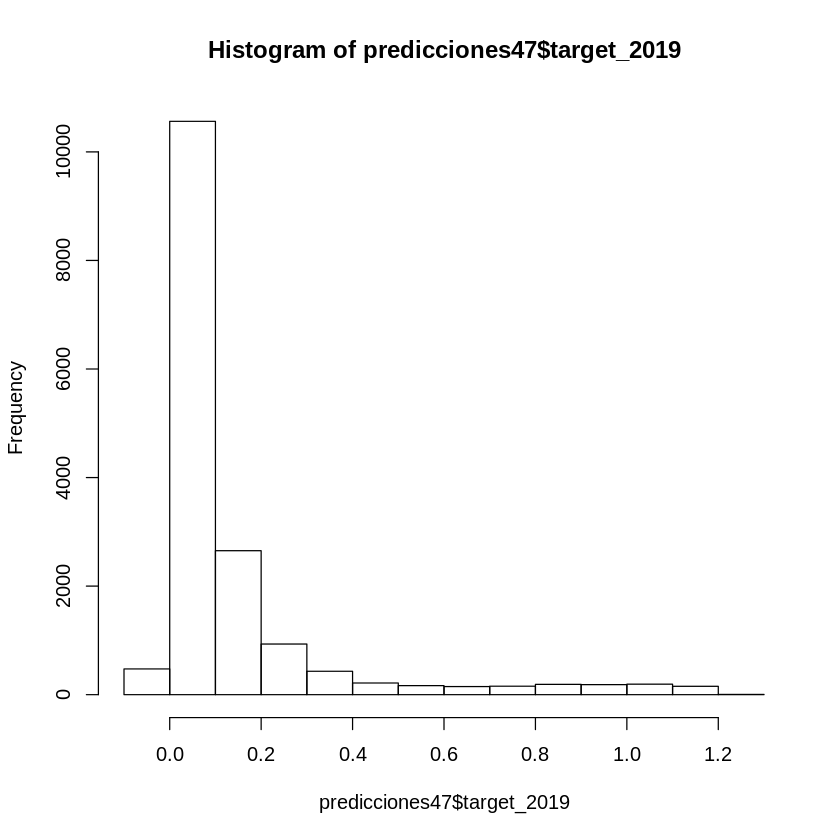

In [0]:
hist(predicciones47$target_2019)

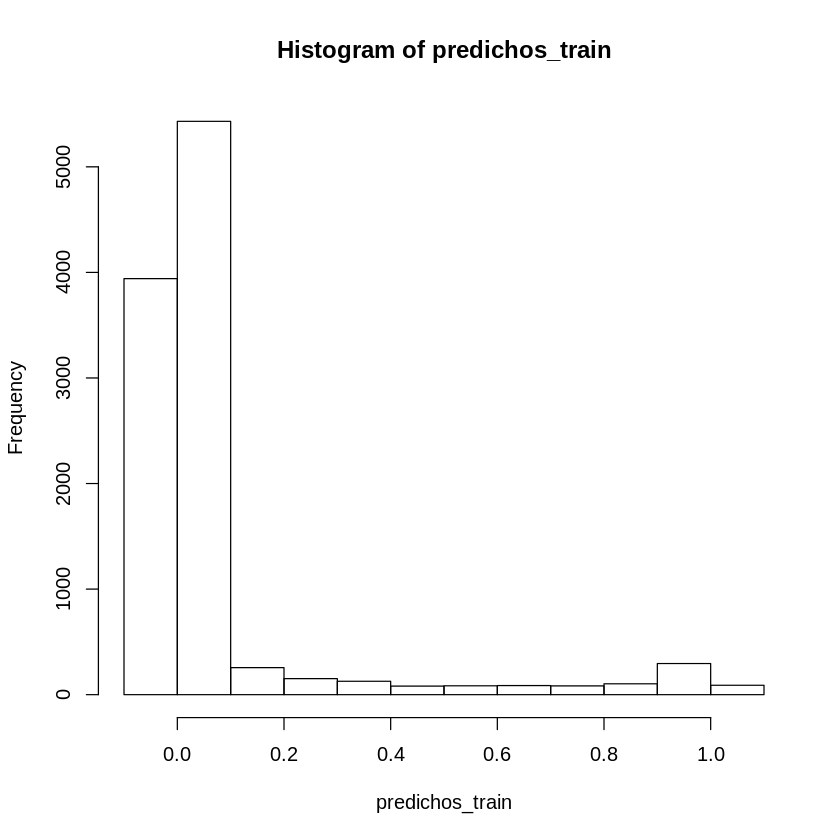

In [0]:
hist(predichos_train)

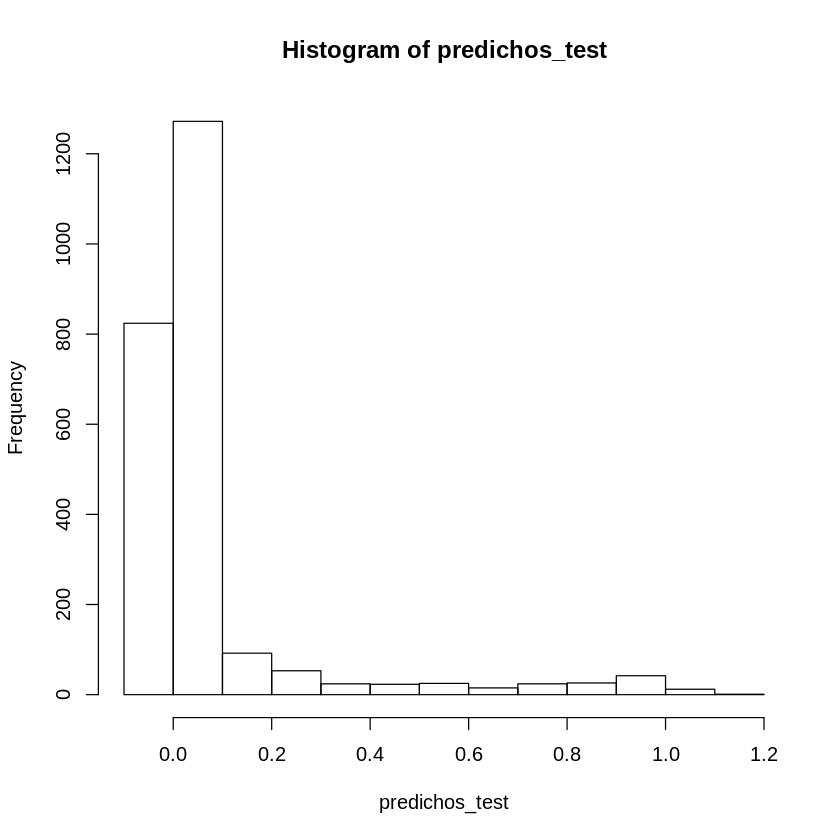

In [0]:
hist(predichos_test)

In [0]:
table(predichos_2019 > 1)


FALSE  TRUE 
16114   352 

In [0]:
table(predichos_2019 < 0)


FALSE  TRUE 
15992   474 

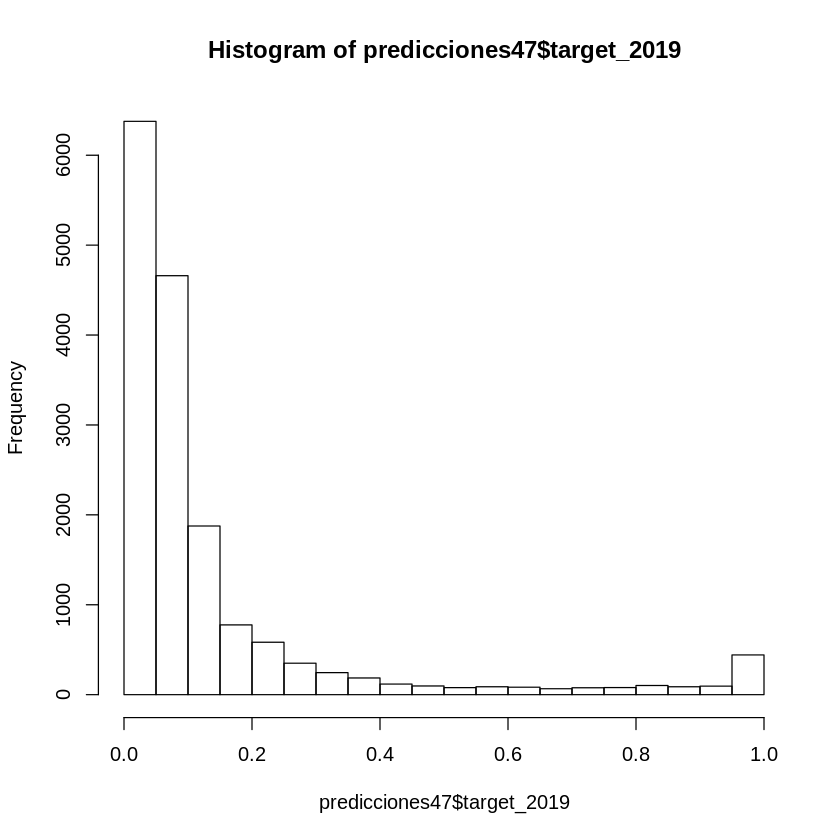

In [0]:
# Exportando predicciones
predicciones47$target_2019[predicciones47$target_2019 > 1] = 1
predicciones47$target_2019[predicciones47$target_2019 < 0] = 0
hist(predicciones47$target_2019)

In [0]:
write.csv(predicciones47, file = "Submussion47.csv", row.names = FALSE)

# Predicciones Modelo 2

In [0]:
# Mejor modelo
modelo_xgb2 <- h2o.getModel(resultados_grid_xgb@model_ids[[2]])
# ============================= Predicciones ====================================== #

# Train 2015
predichos_train <- h2o.predict(modelo_xgb2, datos_train_h2o) %>%
  as.data.frame() %>% pull(predict)

# Test 2015
predichos_test <- h2o.predict(modelo_xgb2, datos_test_h2o) %>%
  as.data.frame() %>% pull(predict)

# Test 2019 (Zindi Submission)
predichos_2019 <- h2o.predict(modelo_xgb2, df_test_2019_h2o) %>%
  as.data.frame() %>% pull(predict)
df_test %>% 
  select(Square_ID) %>% 
  mutate(target_2019 = predichos_2019) ->
  predicciones48

RMSE <- function(pred, obs, na.rm = FALSE){
  sqrt(mean((pred - obs)^2, na.rm = na.rm))
}

data.frame(
  data = c("Train", "Test"),
  RMSE = c(RMSE(pred = predichos_train, obs = as.vector(datos_train_h2o$target_2015)),
           RMSE(pred = predichos_test, obs = as.vector(datos_test_h2o$target_2015)))
)


  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%


data,RMSE
<fct>,<dbl>
Train,0.03902775
Test,0.10288270


In [0]:
# Exportando predicciones
write.csv(predicciones48, file = "Submussion48.csv", row.names = FALSE)